<bound method NDFrame.head of      Relaxation  Rizou  ProducerConsumer  Random  GlobalOptimalBDP  MDCEP  \
0             0      0                 0       0                 1      0   
1             0      0                 0       0                 1      0   
2             0      0                 0       0                 1      0   
3             0      0                 0       0                 1      0   
4             0      0                 0       0                 1      0   
..          ...    ...               ...     ...               ...    ...   
114           0      0                 0       0                 1      0   
115           0      0                 0       0                 1      0   
116           0      0                 0       0                 1      0   
117           0      0                 0       0                 1      0   
118           1      0                 0       0                 0      0   

     eventSizeInKB  eventSizeOutKB  operatorS

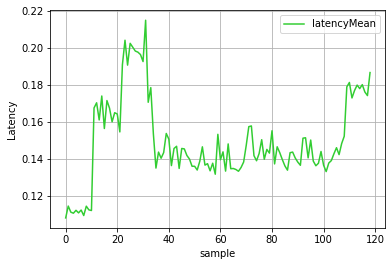

In [6]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from river import linear_model, tree, neural_net, ensemble, stream, metrics, preprocessing, evaluate, compose, optim
from river.neural_net import activations
from river import expert # ~ online hyper parameter tuning

if __name__ == "__main__":

    filename = "stats-Conjunction11bf7aeaea-87321827.csv"
    f = open(filename)
    df = pd.read_csv(f, sep=";", header=0)
    f.close()
    df = df._get_numeric_data()
    #print(df)
    numeric_headers = list(df.columns.values)
    #print(numeric_headers)
    df = df[ np.abs(df['e2eLatencyMean'] - df['e2eLatencyMean'].mean(axis=0)) <= 2 * df['e2eLatencyMean'].std(axis=0) ]
    print(df.head)

    plt.plot(df["processingLatencyMean"], label="latencyMean", color="limegreen")
    plt.grid()
    plt.legend()
    plt.ylabel("Latency")
    plt.xlabel("sample")

    df.to_csv('/tmp/samples_with_comma.csv', sep=',', index=None)

current target:  eventRateOut

current model:  LinearRegression
model init finished
['GlobalOptimalBDP', 'MDCEP', 'ProducerConsumer', 'Random', 'Relaxation', 'Rizou', 'eventRateIn', 'operatorSelectivity', 'processingLatencyMean', 'processingLatencyStdDev'] | StandardScaler | LinearRegression
starting progressive eval
[10] MAE: 2,065.70159
[20] MAE: 1,646.425112
[30] MAE: 1,241.0068
[40] MAE: 1,051.938131
[50] MAE: 914.658276
[60] MAE: 804.569621
[70] MAE: 748.938938
[80] MAE: 690.400924
[90] MAE: 657.760844
[100] MAE: 674.821777
[110] MAE: 684.605367
model perf is  MAE: 651.782579

current model:  PARegressor
model init finished
['GlobalOptimalBDP', 'MDCEP', 'ProducerConsumer', 'Random', 'Relaxation', 'Rizou', 'eventRateIn', 'operatorSelectivity', 'processingLatencyMean', 'processingLatencyStdDev'] | StandardScaler | PARegressor
starting progressive eval
[10] MAE: 772.306621
[20] MAE: 873.560773
[30] MAE: 903.929825
[40] MAE: 908.437409
[50] MAE: 912.804144
[60] MAE: 916.249474
[70] MA

ValueError: shapes (1,12) and (10,5) not aligned: 12 (dim 1) != 10 (dim 0)

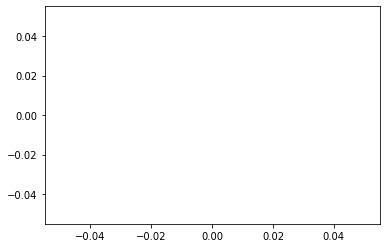

In [7]:
    online_models_base = [
        linear_model.LinearRegression(),
        linear_model.PARegressor(),
        tree.HoeffdingTreeRegressor(),
        tree.HoeffdingAdaptiveTreeRegressor(),  # +ADWIN concept-drift detector
        ensemble.AdaptiveRandomForestRegressor(),
        neural_net.MLPRegressor(
          hidden_dims=(5,),
          activations=(
              activations.ReLU,
              activations.ReLU,
              activations.Identity
          ))]

    target_features = ['eventRateOut', 'processingLatencyMean']
    online_models = {name: online_models_base.copy() for name in target_features }

    selected_features_throughput = compose.Select('Relaxation', 'Rizou', 'ProducerConsumer', 'Random', 'GlobalOptimalBDP', 'MDCEP',
                                    'operatorSelectivity', 'eventRateIn', 'processingLatencyMean', 'processingLatencyStdDev')
    selected_features_processing_latency = compose.Select('Relaxation', 'Rizou', 'ProducerConsumer', 'Random', 'GlobalOptimalBDP', 'MDCEP',
                                            'eventSizeInKB', 'operatorSelectivity', 'interArrivalMean', 'interArrivalStdDev',
                                            'brokerCPULoad', 'eventRateOut')
    selected_dict = { 'eventRateOut' : selected_features_throughput, 'processingLatencyMean' : selected_features_processing_latency}
    params = {
    'converters': {
        'Relaxation' : int,
        'Rizou' : int,
        'ProducerConsumer': int,
        'Random' : int,
        'GlobalOptimalBDP': int,
        'MDCEP': int,
        'eventSizeInKB': float,
        'operatorSelectivity': float,
        'interArrivalMean': float,
        'interArrivalStdDev': float,
        'brokerCPULoad': float,
        'eventRateIn': float,
        'eventRateOut': float,
        'processingLatencyMean': float,
        'processingLatencyStdDev': float,
        }
    }
    metric = metrics.MAE()
    #metric = metrics.RMSE()
    #for x, y in stream.iter_csv('/tmp/samples_with_comma.csv', target=target_features[0], **params):
    #    print(x, y)
    plt.plot(clear=True)

    #TODO expert.SuccessiveHalvingRegressor()

    for t in target_features:
        print("current target: ", t)
        for model in online_models[t]:
            print("\ncurrent model: ", model)
            pipeline = selected_dict[t]
            pipeline |= preprocessing.StandardScaler()
            pipeline |= model
            print("model init finished")
            print(pipeline)

            print("starting progressive eval")

            perf = evaluate.progressive_val_score(
                stream.iter_csv('/tmp/samples_with_comma.csv', target=t, **params),
                pipeline, metric, print_every=10)

            print("model perf is ", perf)